# Import data and libraries ----------------------

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
#import tensorflow_text
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
#Word2Vec wiki model
import urllib.request
import zipfile
import os

# keras layers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense,Concatenate,Conv1D,GlobalMaxPooling1D,SpatialDropout1D,Dropout

#CNN model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV


# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from keras.models import load_model
from keras.models import Model
from keras.layers.merge import concatenate

In [ ]:
df = pd.read_csv('./uss_cleaned.csv')
df['a_clean_content'] = df['a_clean_content'].astype(str)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,a_docId,a_comment_date,a_content_comment,a_rating,approximate_sentiment,a_clean_content
0,1,Mar-22,"Terrible !!!...open at 12 noon, close at 7pm. ...",1,0,terrible open noon close pm queue min ride can...
1,2,Feb-22,I see other people's reviews about a lot of it...,4,2,people review lot closed enjoy went sunday mor...
2,3,Feb-22,"As several previous reviewers have noted, the ...",2,0,previous reviewer note way operate moment make...
3,8,Feb-22,"We paid FULL price for the tickets, only to fi...",1,0,pay price ticket find ride show closed ride re...
4,9,Feb-22,"Multiple rides, shows (100% of the shows were ...",1,0,multiple ride show show available visit street...


In [ ]:
# Check for null values and shape of df
print('----------Null values----------')
print(df.isnull().values.any())
print('----------DF shape----------')
print(df.shape)

----------Null values----------
False
----------DF shape----------
(10108, 6)


## Add approximate sentiment

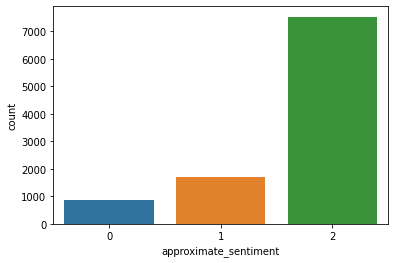

In [ ]:
#Ratings 1, 2: Negative (class 0)
#Rating 3: Neutral (class 1)
#Rating 4, 5: Positive (class 2)
    
class_names = ['Negative' , 'Neutral' , 'Positive']
#View the approximate sentiment of the reviews, if there many neutral classes
#Later will have to used weighted F1 score to tackle the issue of imbalanced dataset
import seaborn as sns
sns.countplot(x='approximate_sentiment', data=df)


# Data Preparation ----------------------

## Test-train split

In [ ]:
from sklearn.model_selection import train_test_split


X_train, x_test, y_train, y_test = train_test_split(df['a_clean_content'] ,  df['approximate_sentiment'] , test_size=0.2)

X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)



## Text tokenization

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['a_clean_content'] )

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(x_test)
sequence_valid = tokenizer.texts_to_sequences(x_val)
index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12505


## Pad the texts

In [ ]:
max_seq_len = 500
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len)
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len)
X_valid_pad = pad_sequences(sequence_valid , maxlen = max_seq_len)
X_train_pad

array([[   0,    0,    0, ...,    4,   32,   18],
       [   0,    0,    0, ...,  214,   46, 9977],
       [   0,    0,    0, ...,    5,   19,    1],
       ...,
       [   0,    0,    0, ...,   18,  202,   29],
       [   0,    0,    0, ...,   33,   39,    4],
       [   0,    0,    0, ..., 8196,  108,    3]], dtype=int32)

In [ ]:
# load library
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE()

# fit target and predictor variable
X_train_pad , y_smote_train = smote.fit_resample(X_train_pad, y_train)


print('Origianl dataset shape:', Counter(y_train))
print('Resampple dataset shape:', Counter(y_smote_train))

Origianl dataset shape: Counter({2: 4553, 1: 1015, 0: 496})
Resampple dataset shape: Counter({2: 4553, 0: 4553, 1: 4553})


In [ ]:

y_smote_train = to_categorical(y_smote_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)


# Transferred learning with Word2Vec & Wiki news

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath , 'r' , encoding='UTF-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
fname = 'embeddings/wiki-news-300d-1M.vec'
if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [ ]:
# Number of dimensions for word embedding
embedding_dim = 128
embedd_matrix = create_embedding_matrix(fname, index_of_words, embedding_dim)
embedd_matrix.shape

(12506, 128)

In [ ]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 10566
New words found: 1939


# Convolutional Neural Network (CNN) ----------------------


In [ ]:
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, embedding_dim, weights = [embedd_matrix], input_length=max_seq_len))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(len(class_names), activation='softmax'))
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1600768   
                                                                 
 conv1d (Conv1D)             (None, 496, 128)          82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,684,139
Trainable params: 1,684,139
Non-trainable params: 0
______________________________________________

In [ ]:
batch_size = 32
epochs = 20

hist = cnn_model.fit(X_train_pad,y_smote_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 callbacks=[tf.keras.callbacks.EarlyStopping(patience=5 , restore_best_weights = True)],
                 validation_data=(X_valid_pad,y_val)
                 )

Epoch 1/20
427/427 [==============================] - 103s 236ms/step - loss: 0.8999 - accuracy: 0.5104 - val_loss: 0.6568 - val_accuracy: 0.7280
Epoch 2/20
427/427 [==============================] - 96s 226ms/step - loss: 0.6137 - accuracy: 0.6771 - val_loss: 0.6358 - val_accuracy: 0.7468
Epoch 3/20
427/427 [==============================] - 92s 216ms/step - loss: 0.4628 - accuracy: 0.7738 - val_loss: 0.6702 - val_accuracy: 0.7626
Epoch 4/20
427/427 [==============================] - 92s 215ms/step - loss: 0.3084 - accuracy: 0.8697 - val_loss: 0.8043 - val_accuracy: 0.7280
Epoch 5/20
427/427 [==============================] - 91s 214ms/step - loss: 0.1359 - accuracy: 0.9596 - val_loss: 0.9553 - val_accuracy: 0.7171
Epoch 6/20
427/427 [==============================] - 91s 213ms/step - loss: 0.0367 - accuracy: 0.9939 - val_loss: 1.0117 - val_accuracy: 0.7394
Epoch 7/20
427/427 [==============================] - 91s 214ms/step - loss: 0.0097 - accuracy: 0.9994 - val_loss: 1.0544 - val_a

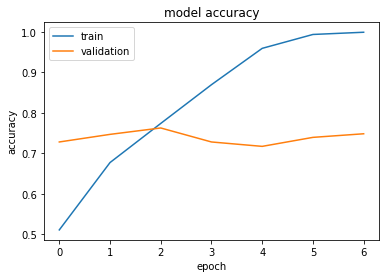

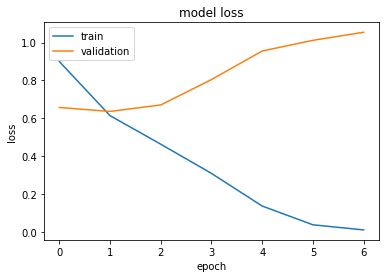

In [ ]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
predictions = cnn_model.predict(X_test_pad) #Method used to predict valid later
predictions = np.argmax(predictions, axis=1)
print("Accuracy: {:.2f}%".format(accuracy_score(np.argmax(y_test, axis=1), predictions) * 100))

CNN_eval = accuracy_score(np.argmax(y_test, axis=1), predictions) * 100

Accuracy: 75.12%


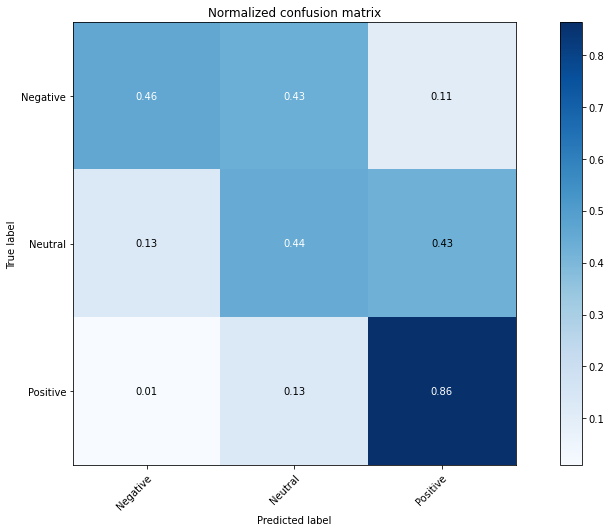

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(np.argmax(y_test, axis=1), predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
# Classfication Report for CNN model

from sklearn.metrics import classification_report

cf_CNN = classification_report(np.argmax(y_test, axis=1), predictions, target_names = class_names)
print(cf_CNN)

              precision    recall  f1-score   support

    Negative       0.59      0.46      0.52       189
     Neutral       0.37      0.44      0.40       356
    Positive       0.88      0.86      0.87      1477

    accuracy                           0.75      2022
   macro avg       0.61      0.59      0.60      2022
weighted avg       0.76      0.75      0.76      2022



In [ ]:
# Weighted F1 score for CNN model

from sklearn.metrics import f1_score
f1_wt_CNN = f1_score(np.argmax(y_test, axis=1), predictions, average = 'weighted') * 100
print("\nWeighted F1 Score: {:.2f}".format(f1_score(np.argmax(y_test, axis=1), predictions, average = 'weighted')* 100))


Weighted F1 Score: 75.60


# Long Short-Term Memory (LSTM) ----------------------

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_dim, weights = [embedd_matrix], input_length=max_seq_len))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(64, return_sequences = True))
lstm_model.add(GlobalMaxPooling1D())
lstm_model.add(Dense(16, activation="relu"))
lstm_model.add(Dropout(0.25))
lstm_model.add(Dense(len(class_names), activation='softmax'))

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          1600768   
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 500, 64)           49408     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                      

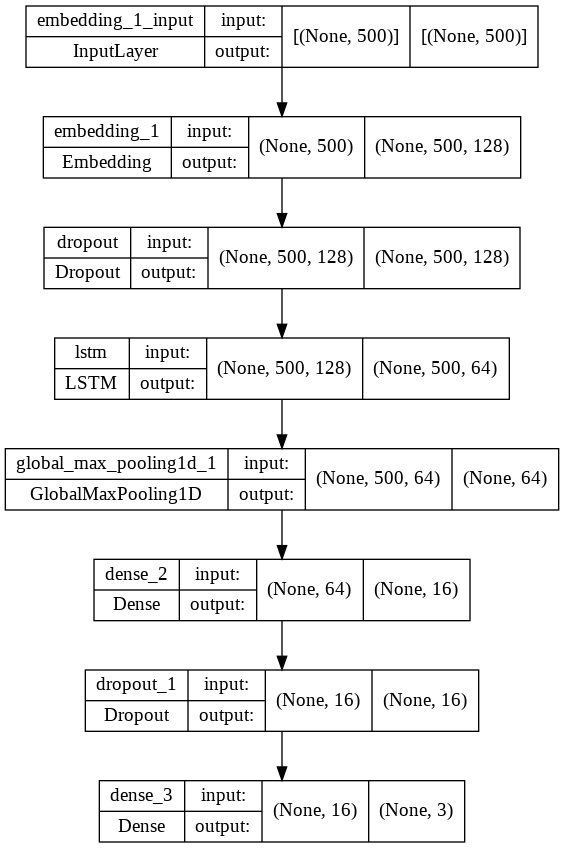

In [ ]:
tf.keras.utils.plot_model(lstm_model, show_shapes=True)

In [ ]:
batch_size = 32
epochs = 20

hist = lstm_model.fit(X_train_pad,y_smote_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 callbacks=[tf.keras.callbacks.EarlyStopping(patience=10 , restore_best_weights = True)],
                 validation_data=(X_valid_pad,y_val)
                 )

Epoch 1/20
427/427 [==============================] - 185s 428ms/step - loss: 0.9953 - accuracy: 0.4760 - val_loss: 0.8955 - val_accuracy: 0.6044
Epoch 2/20
427/427 [==============================] - 181s 423ms/step - loss: 0.8132 - accuracy: 0.5962 - val_loss: 0.6993 - val_accuracy: 0.7127
Epoch 3/20
427/427 [==============================] - 181s 425ms/step - loss: 0.7063 - accuracy: 0.6405 - val_loss: 0.6667 - val_accuracy: 0.7186
Epoch 4/20
427/427 [==============================] - 181s 425ms/step - loss: 0.6363 - accuracy: 0.6801 - val_loss: 0.6789 - val_accuracy: 0.7255
Epoch 5/20
427/427 [==============================] - 183s 428ms/step - loss: 0.5815 - accuracy: 0.7047 - val_loss: 0.6460 - val_accuracy: 0.7369
Epoch 6/20
427/427 [==============================] - 182s 425ms/step - loss: 0.5386 - accuracy: 0.7306 - val_loss: 0.7680 - val_accuracy: 0.7221
Epoch 7/20
427/427 [==============================] - 182s 426ms/step - loss: 0.5015 - accuracy: 0.7583 - val_loss: 0.8125 -

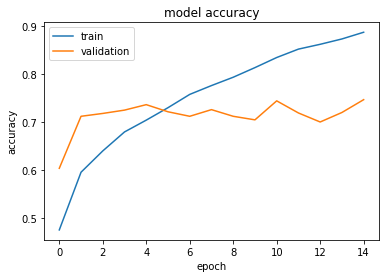

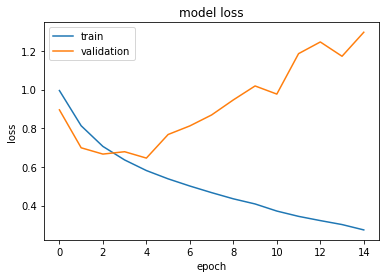

In [ ]:
# "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = lstm_model.predict(X_test_pad)#Method used to predict valid later
predictions = np.argmax(predictions, axis=1)
print("Accuracy: {:.2f}%".format(accuracy_score(np.argmax(y_test, axis=1), predictions) * 100))

LSTM_eval = accuracy_score(np.argmax(y_test, axis=1), predictions) * 100

Accuracy: 74.68%


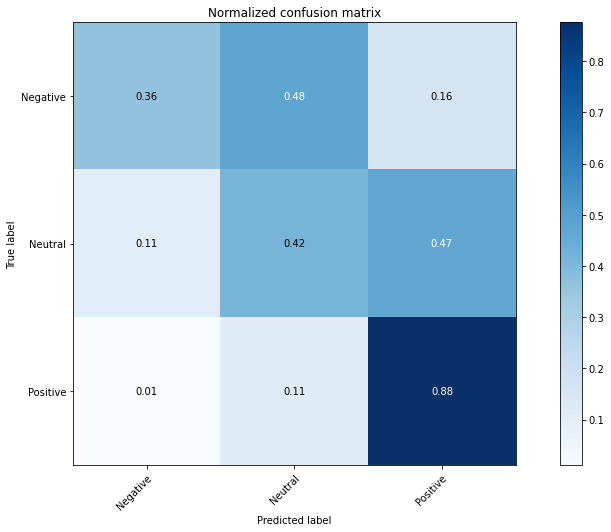

In [ ]:
plot_confusion_matrix(np.argmax(y_test, axis=1), predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
# Classfication Report for LSTM model

from sklearn.metrics import classification_report

cf_LSTM = classification_report(np.argmax(y_test, axis=1), predictions, target_names = class_names)
print(cf_LSTM)

              precision    recall  f1-score   support

    Negative       0.54      0.36      0.43       189
     Neutral       0.37      0.42      0.39       356
    Positive       0.87      0.88      0.87      1477

    accuracy                           0.75      2022
   macro avg       0.59      0.55      0.57      2022
weighted avg       0.75      0.75      0.75      2022



In [ ]:
# Weighted F1 score for LSTM model

from sklearn.metrics import f1_score
f1_wt_LSTM = f1_score(np.argmax(y_test, axis=1), predictions, average = 'weighted') * 100
print("\nWeighted F1 Score: {:.2f}".format(f1_score(np.argmax(y_test, axis=1), predictions, average = 'weighted')* 100))


Weighted F1 Score: 74.58


## Save Models

In [ ]:
cnn_model.save("./models/cnn_model.h5")
lstm_model.save("./models/lstm_model.h5")

# Combination of CNN and LSTM ----------------------

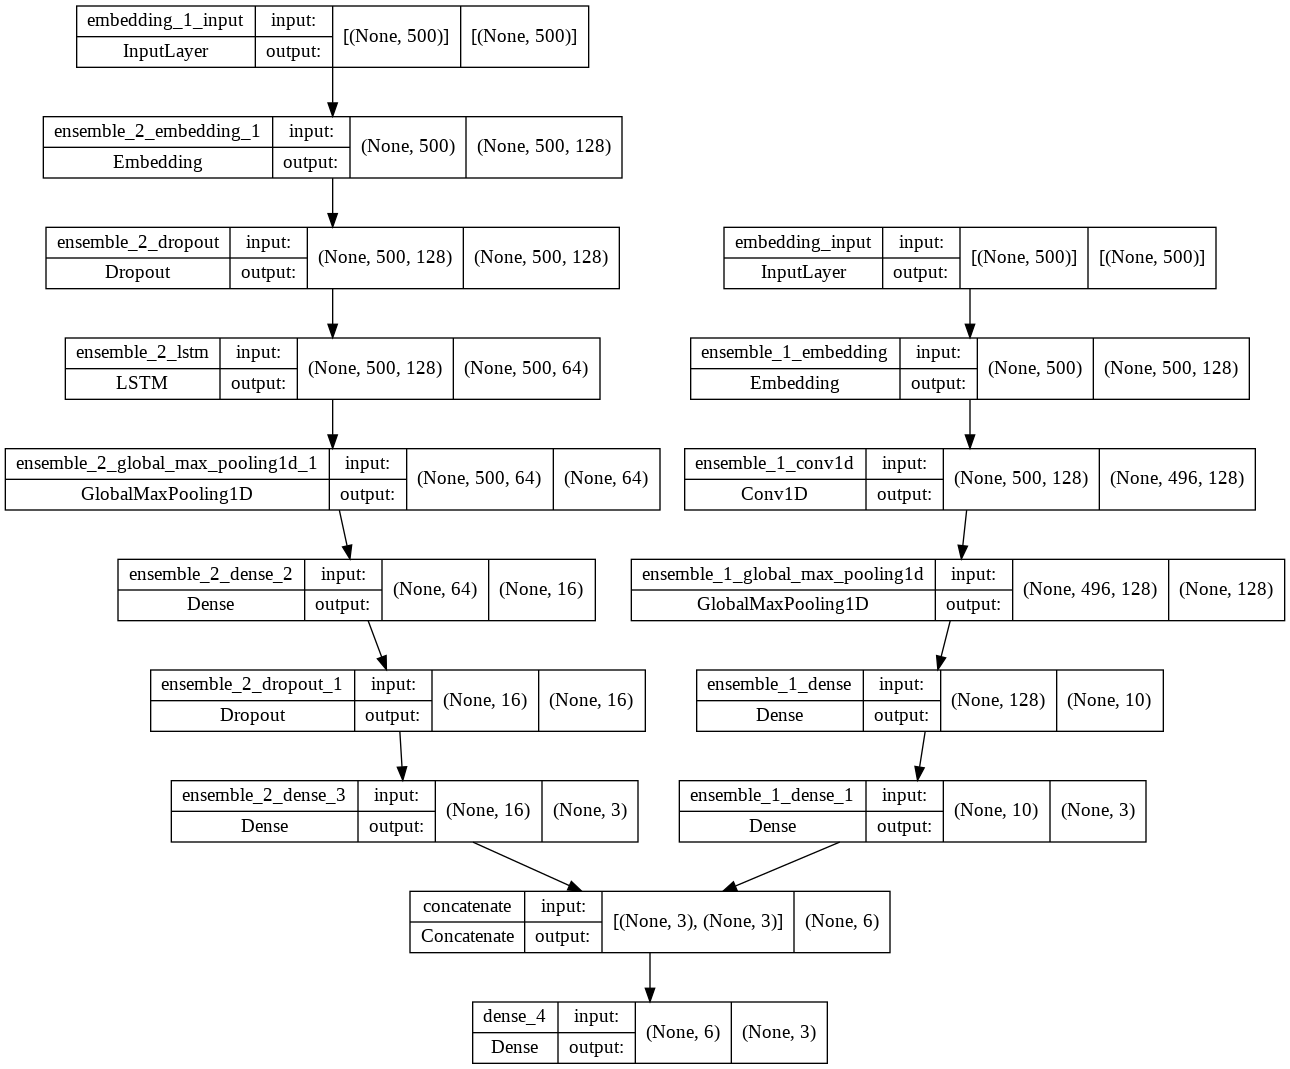

In [ ]:
cnn_model = load_model("./models/cnn_model.h5")
lstm_model = load_model("./models/lstm_model.h5")

all_models = []
all_models.append(cnn_model)
all_models.append(lstm_model)

for i in range(len(all_models)):
  model = all_models[i]
  model._name = 'model_' + str(i)

  for layer in model.layers:
    layer.trainable = False
    layer._name = 'ensemble_' + str(i+1) + '_' +  layer.name

ensemble_input = [model.input for model in all_models]
ensemble_output = [model.output for model in all_models]
merge = concatenate(ensemble_output)
output = Dense(len(class_names) , activation = 'softmax')(merge)
stacked_model = Model(inputs=ensemble_input, outputs=output)
stacked_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

tf.keras.utils.plot_model(stacked_model, show_shapes=True)

In [ ]:
def fit_stacked_model(model, x_train, y_train,x_valid,y_valid):
    # fit model
    x_train_ = [x_train for _ in range(len(model.input))]
    x_valid_ = [x_valid for _ in range(len(model.input))]
    history = model.fit(x_train_ , y_train, 
                epochs=20, 
                batch_size=32,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights = True)],
                validation_data=(x_valid_,y_valid)
                )
    return history
hist = fit_stacked_model(stacked_model, X_train_pad, y_smote_train,X_valid_pad,y_val)

Epoch 1/20
427/427 [==============================] - 91s 208ms/step - loss: 0.9280 - accuracy: 0.4378 - val_loss: 0.8278 - val_accuracy: 0.6627
Epoch 2/20
427/427 [==============================] - 71s 166ms/step - loss: 0.6848 - accuracy: 0.6446 - val_loss: 0.6971 - val_accuracy: 0.7166
Epoch 3/20
427/427 [==============================] - 71s 167ms/step - loss: 0.5864 - accuracy: 0.7622 - val_loss: 0.6616 - val_accuracy: 0.7502
Epoch 4/20
427/427 [==============================] - 70s 165ms/step - loss: 0.5341 - accuracy: 0.7816 - val_loss: 0.6532 - val_accuracy: 0.7418
Epoch 5/20
427/427 [==============================] - 70s 163ms/step - loss: 0.5027 - accuracy: 0.7856 - val_loss: 0.6544 - val_accuracy: 0.7438
Epoch 6/20
427/427 [==============================] - 70s 164ms/step - loss: 0.4791 - accuracy: 0.7908 - val_loss: 0.6605 - val_accuracy: 0.7443
Epoch 7/20
427/427 [==============================] - 70s 164ms/step - loss: 0.4634 - accuracy: 0.7873 - val_loss: 0.6715 - val_ac

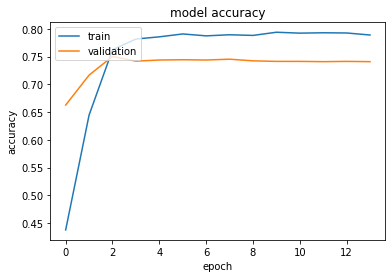

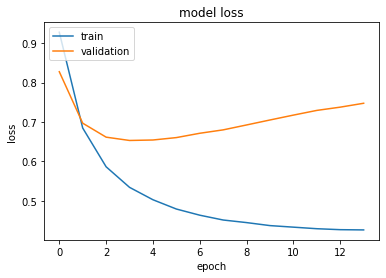

In [ ]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
x_test = [X_test_pad for _ in range(len(stacked_model.input))]
predictions = stacked_model.predict(x_test)

predictions = np.argmax(predictions, axis=1)

print("Accuracy: {:.2f}%".format(accuracy_score(np.argmax(y_test, axis=1), predictions) * 100))



Ensemble_eval = accuracy_score(np.argmax(y_test, axis=1), predictions) * 100

Accuracy: 75.47%


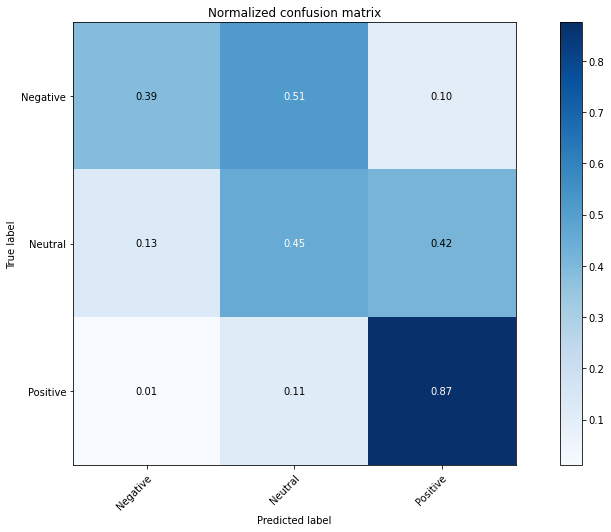

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(np.argmax(y_test, axis=1), predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

cf_ensemble = classification_report(np.argmax(y_test, axis=1), predictions, target_names = class_names)
print(cf_ensemble)

              precision    recall  f1-score   support

    Negative       0.54      0.39      0.45       189
     Neutral       0.38      0.45      0.41       356
    Positive       0.88      0.87      0.88      1477

    accuracy                           0.75      2022
   macro avg       0.60      0.57      0.58      2022
weighted avg       0.76      0.75      0.76      2022



In [ ]:
# Weighted F1 score for Ensemble model

from sklearn.metrics import f1_score
f1_wt_Ensemble = f1_score(np.argmax(y_test, axis=1), predictions, average = 'weighted') * 100
print("\nWeighted F1 Score: {:.2f}".format(f1_score(np.argmax(y_test, axis=1), predictions, average = 'weighted')* 100))


Weighted F1 Score: 75.72


# Performance Comparison---------------------

In [ ]:
# Performance for test dataset

metrics_data = [[CNN_eval, f1_wt_CNN], 
                [LSTM_eval, f1_wt_LSTM],
                [Ensemble_eval, f1_wt_Ensemble]]
metrics_df = pd.DataFrame(metrics_data, index = ['CNN', 'LSTM', 'Ensemble'],
                    columns = ['Accuracy', 'Weighted F1 Score'])
metrics_df

,Accuracy,Weighted F1 Score
CNN,75.123640,75.597716
LSTM,74.678536,74.578829
Ensemble,75.469832,75.715689
